# **Porto Seguro's Safe Driver Prediction**
Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.


### Mining Objectives
The objective is use supervised learning technical for understend how severe is an insurance claim.

## **Prepare Environment**

<br/>

### Imports

In [198]:
# data analysis and data wrangling
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import LabelEncoder

# machine learning
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# Other
from IPython.display import Image
import configparser
import subprocess
import warnings
import pprint
import time
import os

<br/>

### Prepare Principal Directory

In [199]:
def path_to_work(end_directory: str='notebooks'):
    curr_dir = os.path.dirname(os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return f'Change directory to: {curr_dir}'
    
    return f'Current working directory: {curr_dir}'

In [200]:
path_to_work('notebooks')

'Current working directory: /home/campos/projects/porto-seguro-safe-driver-prediction'

<br/>

### Set Config

In [201]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500, 
    'figure.autolayout': True, 
    'figure.figsize': [17, 12], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 10, 
    'lines.linewidth': 1.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 15,
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True, 
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## **Data Understanding**

### Collect Initial Data
The data set to be explored is the Porto Seguro’s Safe Driver Prediction hosted in [Kaggle Competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)


### File Descriptions
- `train.csv` contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
- `test.csv` contains the test data.
- `sample_submission.csv` is submission file showing the correct format.

### Load Data

> Unzip files to work this data!

In [202]:
%%time

df_train = pd.read_csv('data/raw/train.csv', 
                       na_values=-1,
                       sep=',',
                       encoding='utf-8')
df_test = pd.read_csv('data/raw/test.csv', 
                      na_values=-1,
                      sep=',',
                      encoding='utf-8')

CPU times: user 6.86 s, sys: 2.1 s, total: 8.95 s
Wall time: 9.13 s


---

## **Describe Data**

In this competition, you will predict the probability that an auto insurance policy holder files a claim.
In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal.
- Values of -1 indicate that the feature was _missing_ from the observation.
- `target` columns signifies whether or not a claim was filed for that policy holder.
- `Ind` is related to individual or driver
- `reg` is related to region
- `car` is related to car itself
- `calc` is an calculated feature

In [203]:
# Required column for kaggle submition
id_test = df_test['id'].values

In [204]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  float64
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  float64
 6   ps_ind_05_cat   595212 non-null  float64
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [205]:
train.head(2)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.00,5,1.00,0.00,0,1,0,0,0,0,0,0,0,11,0,1,0,0.70,0.20,0.72,10.00,1.00,-1.00,0,1.00,4,1.00,0,0.00,1,12,2.00,0.40,0.88,0.37,3.61,0.60,0.50,0.20,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.00,7,0.00,0.00,0,0,1,0,0,0,0,0,0,3,0,0,1,0.80,0.40,0.77,11.00,1.00,-1.00,0,-1.00,11,1.00,1,2.00,1,19,3.00,0.32,0.62,0.39,2.45,0.30,0.10,0.30,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0


In [206]:
test.head(2)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.00,8,1.00,0.00,0,1,0,0,0,0,0,0,0,12,1,0,0,0.50,0.30,0.61,7.00,1.00,-1.00,0,-1.00,1,1.00,1,2.00,1,65,1.00,0.32,0.67,0.35,3.46,0.10,0.80,0.60,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2.00,5,1.00,0.00,0,0,0,1,0,0,0,0,0,5,1,0,0,0.90,0.50,0.77,4.00,1.00,-1.00,0,0.00,11,1.00,1,0.00,1,103,1.00,0.32,0.61,0.36,2.83,0.40,0.50,0.40,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1


In [207]:
print("Dataframe:\n{} rows\n{} columns"
      .format(df_train.shape[0],
              df_train.shape[1]))

Dataframe:
595212 rows
59 columns


---

## **Explore Data**

In [208]:
print(df_train.nunique())

id                595212
target                 2
ps_ind_01              8
ps_ind_02_cat          4
ps_ind_03             12
ps_ind_04_cat          2
ps_ind_05_cat          7
ps_ind_06_bin          2
ps_ind_07_bin          2
ps_ind_08_bin          2
ps_ind_09_bin          2
ps_ind_10_bin          2
ps_ind_11_bin          2
ps_ind_12_bin          2
ps_ind_13_bin          2
ps_ind_14              5
ps_ind_15             14
ps_ind_16_bin          2
ps_ind_17_bin          2
ps_ind_18_bin          2
ps_reg_01             10
ps_reg_02             19
ps_reg_03           5012
ps_car_01_cat         12
ps_car_02_cat          2
ps_car_03_cat          2
ps_car_04_cat         10
ps_car_05_cat          2
ps_car_06_cat         18
ps_car_07_cat          2
ps_car_08_cat          2
ps_car_09_cat          5
ps_car_10_cat          3
ps_car_11_cat        104
ps_car_11              4
ps_car_12            183
ps_car_13          70482
ps_car_14            849
ps_car_15             15
ps_calc_01            10


In [209]:
def show_measures_location(df: pd.core.frame.DataFrame, type_descr: list) -> None:
    """
    Function get measures localization
    Handler when type data not exists
    
    Args:
    type_descr
        np.number, np.object  -> return summary statistic with all columns
        np.number             -> return summary statistic numerical columns 
        np.object             -> return summary statistic object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n\n')    
    else:
        list_col = col.tolist()
        percentage = (len(list_col) / df.shape[1]) * 100
        
        print("-"*25, "MEASURES OF LOCALIZATION", "-"*25, end='\n\n')
        print(f"TOTAL columns {type_descr}: {len(list_col)}")
        print("PERCENTAGE {} in dataframe: {:3.4} %".format(type_descr, percentage))
        
        return df.describe(include=type_descr)

In [210]:
show_measures_location(df=df_train,
                       type_descr=[np.number, np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>, <class 'object'>]: 59
PERCENTAGE [<class 'numpy.number'>, <class 'object'>] in dataframe: 100.0 %


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.00,595212.00,595212.00,594996.00,595212.00,595129.00,589403.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,487440.00,595105.00,595207.00,183981.00,595212.00,328661.00,595212.00,583723.00,595212.00,594643.00,595212.00,595212.00,595207.00,595211.00,595212.00,552592.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00
mean,743803.56,0.04,1.90,1.36,4.42,0.42,0.42,0.39,0.26,0.16,0.19,0.00,0.00,0.01,0.00,0.01,7.30,0.66,0.12,0.15,0.61,0.44,0.89,8.30,0.83,0.60,0.73,0.53,6.56,0.95,0.83,1.33,0.99,62.22,2.35,0.38,0.81,0.37,3.07,0.45,0.45,0.45,2.37,1.89,7.69,3.01,9.23,2.34,8.43,5.44,1.44,2.87,7.54,0.12,0.63,0.55,0.29,0.35,0.15
std,429367.82,0.19,1.98,0.66,2.70,0.49,1.35,0.49,0.44,0.37,0.39,0.02,0.04,0.10,0.03,0.13,3.55,0.47,0.33,0.36,0.29,0.40,0.35,2.51,0.38,0.49,2.15,0.50,5.50,0.22,0.37,0.98,0.09,33.01,0.83,0.06,0.22,0.05,0.73,0.29,0.29,0.29,1.12,1.13,1.33,1.41,1.46,1.25,2.90,2.33,1.20,1.69,2.75,0.33,0.48,0.50,0.45,0.48,0.36
min,7.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.10,0.25,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,371991.50,0.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.40,0.20,0.63,7.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,32.00,2.00,0.32,0.67,0.35,2.83,0.20,0.20,0.20,2.00,1.00,7.00,2.00,8.00,1.00,6.00,4.00,1.00,2.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,743547.50,0.00,1.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,1.00,0.00,0.00,0.70,0.30,0.80,7.00,1.00,1.00,0.00,1.00,7.00,1.00,1.00,2.00,1.00,65.00,3.00,0.37,0.77,0.37,3.32,0.50,0.40,0.50,2.00,2.00,8.00,3.00,9.00,2.00,8.00,5.00,1.00,3.00,7.00,0.00,1.00,1.00,0.00,0.00,0.00
75%,1115548.75,0.00,3.00,2.00,6.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,1.00,0.00,0.00,0.90,0.60,1.08,11.00,1.00,1.00,0.00,1.00,11.00,1.00,1.00,2.00,1.00,93.00,3.00,0.40,0.91,0.40,3.61,0.70,0.70,0.70,3.00,3.00,9.00,4.00,10.00,3.00,10.00,7.00,2.00,4.00,9.00,0.00,1.00,1.00,1.00,1.00,0.00
max,1488027.00,1.00,7.00,4.00,11.00,1.00,6.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.00,13.00,1.00,1.00,1.00,0.90,1.80,4.04,11.00,1.00,1.00,9.00,1.00,17.00,1.00,1.00,4.00,2.00,104.00,3.00,1.26,3.72,0.64,3.74,0.90,0.90,0.90,5.00,6.00,10.00,9.00,12.00,7.00,25.00,19.00,10.00,13.00,23.00,1.00,1.00,1.00,1.00,1.00,1.00


In [211]:
show_measures_location(df=df_train,
                       type_descr=[np.number])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>]: 59
PERCENTAGE [<class 'numpy.number'>] in dataframe: 100.0 %


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.00,595212.00,595212.00,594996.00,595212.00,595129.00,589403.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,487440.00,595105.00,595207.00,183981.00,595212.00,328661.00,595212.00,583723.00,595212.00,594643.00,595212.00,595212.00,595207.00,595211.00,595212.00,552592.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00,595212.00
mean,743803.56,0.04,1.90,1.36,4.42,0.42,0.42,0.39,0.26,0.16,0.19,0.00,0.00,0.01,0.00,0.01,7.30,0.66,0.12,0.15,0.61,0.44,0.89,8.30,0.83,0.60,0.73,0.53,6.56,0.95,0.83,1.33,0.99,62.22,2.35,0.38,0.81,0.37,3.07,0.45,0.45,0.45,2.37,1.89,7.69,3.01,9.23,2.34,8.43,5.44,1.44,2.87,7.54,0.12,0.63,0.55,0.29,0.35,0.15
std,429367.82,0.19,1.98,0.66,2.70,0.49,1.35,0.49,0.44,0.37,0.39,0.02,0.04,0.10,0.03,0.13,3.55,0.47,0.33,0.36,0.29,0.40,0.35,2.51,0.38,0.49,2.15,0.50,5.50,0.22,0.37,0.98,0.09,33.01,0.83,0.06,0.22,0.05,0.73,0.29,0.29,0.29,1.12,1.13,1.33,1.41,1.46,1.25,2.90,2.33,1.20,1.69,2.75,0.33,0.48,0.50,0.45,0.48,0.36
min,7.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.10,0.25,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,371991.50,0.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.40,0.20,0.63,7.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,32.00,2.00,0.32,0.67,0.35,2.83,0.20,0.20,0.20,2.00,1.00,7.00,2.00,8.00,1.00,6.00,4.00,1.00,2.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,743547.50,0.00,1.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,1.00,0.00,0.00,0.70,0.30,0.80,7.00,1.00,1.00,0.00,1.00,7.00,1.00,1.00,2.00,1.00,65.00,3.00,0.37,0.77,0.37,3.32,0.50,0.40,0.50,2.00,2.00,8.00,3.00,9.00,2.00,8.00,5.00,1.00,3.00,7.00,0.00,1.00,1.00,0.00,0.00,0.00
75%,1115548.75,0.00,3.00,2.00,6.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,1.00,0.00,0.00,0.90,0.60,1.08,11.00,1.00,1.00,0.00,1.00,11.00,1.00,1.00,2.00,1.00,93.00,3.00,0.40,0.91,0.40,3.61,0.70,0.70,0.70,3.00,3.00,9.00,4.00,10.00,3.00,10.00,7.00,2.00,4.00,9.00,0.00,1.00,1.00,1.00,1.00,0.00
max,1488027.00,1.00,7.00,4.00,11.00,1.00,6.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.00,13.00,1.00,1.00,1.00,0.90,1.80,4.04,11.00,1.00,1.00,9.00,1.00,17.00,1.00,1.00,4.00,2.00,104.00,3.00,1.26,3.72,0.64,3.74,0.90,0.90,0.90,5.00,6.00,10.00,9.00,12.00,7.00,25.00,19.00,10.00,13.00,23.00,1.00,1.00,1.00,1.00,1.00,1.00


<br/>

### Target Analysis
This column signifies whether or not a claim was filed for that policy holder.
- Go claim
- Dont claim

**NOTE:** never use target how feature

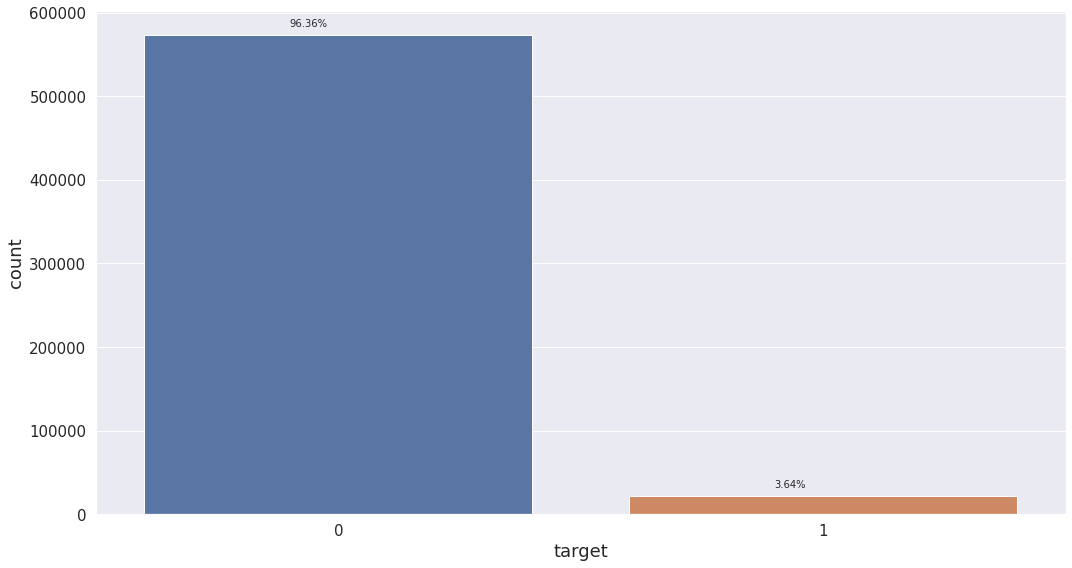

In [212]:
plt.figure(figsize=(15,8))

# faz um agrupamento da coluna 'target'
ax = sns.countplot('target', data=train)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train['target'])), 
                (p.get_x() + 0.3, p.get_height() + 10000))

Only 3.64% a clain

<br/>

### Verify Metadata 

In [213]:
def get_meta(train):
    data = []
    for col in train.columns:
        # Defining the role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the level
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'

        # Initialize keep to True for all variables except for id
        keep = True
        if col == 'id':
            keep = False

        # Defining the data type 
        dtype = train[col].dtype

        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)
    return meta

In [214]:
meta_data = get_meta(train)
display(meta_data)

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,float64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,float64
ps_ind_05_cat,input,nominal,True,float64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [215]:
meta_counts = meta_data\
                    .groupby(['role', 'level'])\
                        .agg({'dtype': lambda x: x.count()})\
                            .reset_index()
display(meta_counts)

,role,level,dtype
0,id,nominal,1
1,input,binary,17
2,input,interval,11
3,input,nominal,14
4,input,ordinal,15
5,target,binary,1


[Text(0.5, 0, 'Variable Type'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Variables Count Across Datatype')]

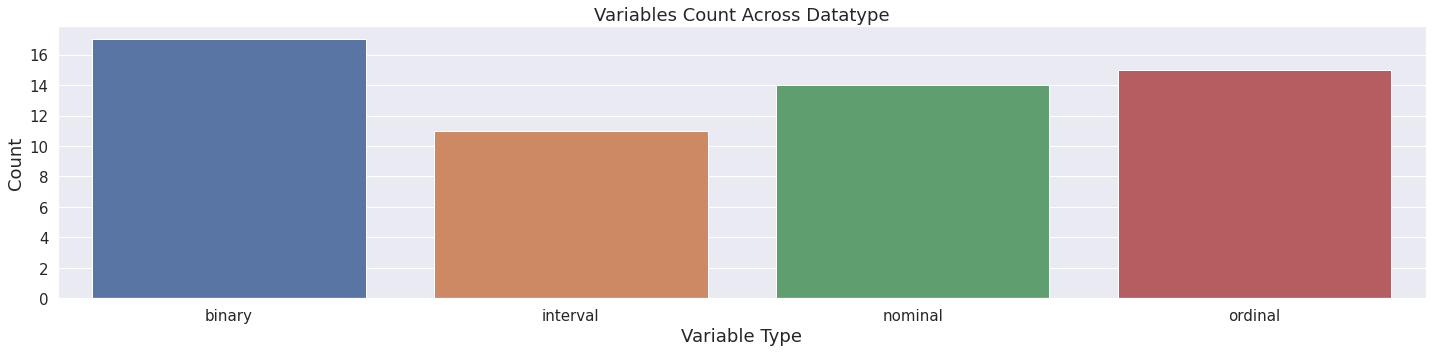

In [216]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=meta_counts[(meta_counts.role != 'target') & (meta_counts.role != 'id') ],
            x="level",
            y="dtype",
            ax=ax)

ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

In [217]:
col_ordinal   = meta_data[(meta_data.level == 'ordinal') & (meta_data.keep)].index
col_nominal   = meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
col_internval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_binary    = meta_data[(meta_data.level == 'binary') & (meta_data.keep) & (meta_data.role != 'target')].index

<br/>

### Correlation Pearson

- if two variables = 1 so it's colinear, in this case the variables are the same thing and possibly **only have different names.**

In [218]:
display(col_internval)

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12',
       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02',
       'ps_calc_03'],
      dtype='object', name='varname')

In [219]:
corr_matrix = train[col_internval].corr()
display(corr_matrix)

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
ps_reg_01,1.00,0.47,0.64,0.08,0.02,0.03,0.01,0.00,-0.00,0.00,-0.00
ps_reg_02,0.47,1.00,0.52,0.07,0.17,0.19,0.00,0.05,0.00,-0.00,0.00
ps_reg_03,0.64,0.52,1.00,0.08,0.08,0.10,0.01,0.02,-0.00,0.00,-0.00
ps_car_11,0.08,0.07,0.08,1.00,0.06,0.10,-0.06,0.11,0.00,0.00,-0.00
ps_car_12,0.02,0.17,0.08,0.06,1.00,0.67,0.01,0.05,-0.00,-0.00,0.00
ps_car_13,0.03,0.19,0.10,0.10,0.67,1.00,-0.04,0.53,0.00,0.00,-0.00
ps_car_14,0.01,0.00,0.01,-0.06,0.01,-0.04,1.00,-0.03,-0.00,0.00,0.00
ps_car_15,0.00,0.05,0.02,0.11,0.05,0.53,-0.03,1.00,0.00,-0.00,-0.00
ps_calc_01,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,1.00,-0.00,0.00
ps_calc_02,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,1.00,0.00


<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

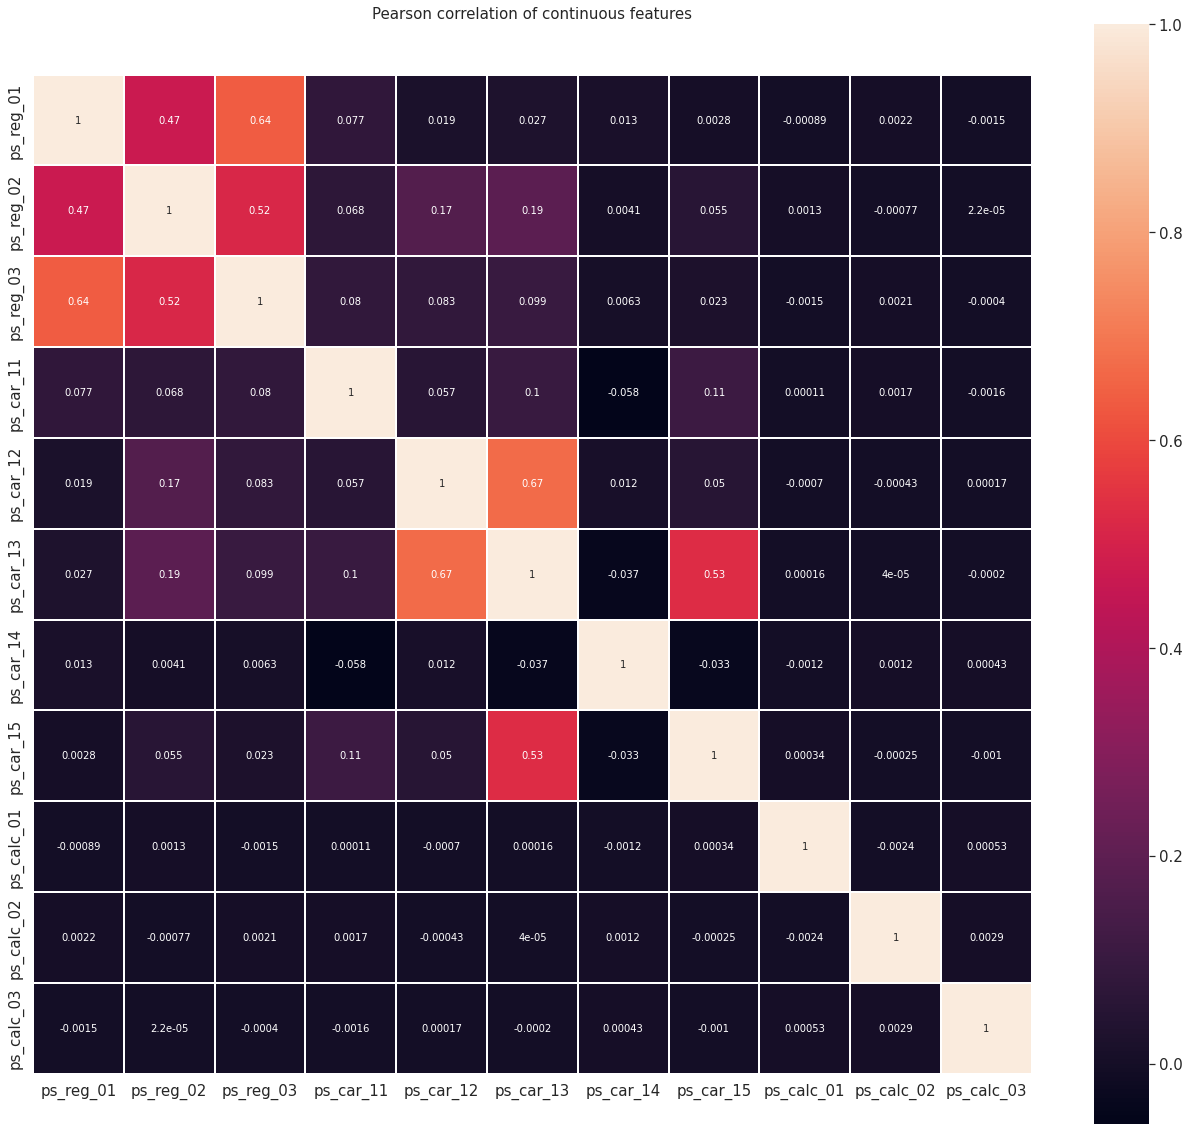

In [220]:
plt.figure(figsize=(18,16))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train[col_internval].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            linecolor='white', 
            annot=True)

---

## **Verify Data Quality**

### Missing Values

In [221]:
# return TRUE if column contains one or more values missing
train.isnull().any()

id                False
target            False
ps_ind_01         False
ps_ind_02_cat     False
ps_ind_03         False
ps_ind_04_cat     False
ps_ind_05_cat     False
ps_ind_06_bin     False
ps_ind_07_bin     False
ps_ind_08_bin     False
ps_ind_09_bin     False
ps_ind_10_bin     False
ps_ind_11_bin     False
ps_ind_12_bin     False
ps_ind_13_bin     False
ps_ind_14         False
ps_ind_15         False
ps_ind_16_bin     False
ps_ind_17_bin     False
ps_ind_18_bin     False
ps_reg_01         False
ps_reg_02         False
ps_reg_03         False
ps_car_01_cat     False
ps_car_02_cat     False
ps_car_03_cat     False
ps_car_04_cat     False
ps_car_05_cat     False
ps_car_06_cat     False
ps_car_07_cat     False
ps_car_08_cat     False
ps_car_09_cat     False
ps_car_10_cat     False
ps_car_11_cat     False
ps_car_11         False
ps_car_12         False
ps_car_13         False
ps_car_14         False
ps_car_15         False
ps_calc_01        False
ps_calc_02        False
ps_calc_03      

In [222]:
missing_value_columns = df_train.columns[df_train.isnull().any()].tolist()
df_null = df_train[missing_value_columns]

In [223]:
pp.pprint(missing_value_columns)

[   'ps_ind_02_cat',
    'ps_ind_04_cat',
    'ps_ind_05_cat',
    'ps_reg_03',
    'ps_car_01_cat',
    'ps_car_02_cat',
    'ps_car_03_cat',
    'ps_car_05_cat',
    'ps_car_07_cat',
    'ps_car_09_cat',
    'ps_car_11',
    'ps_car_12',
    'ps_car_14']


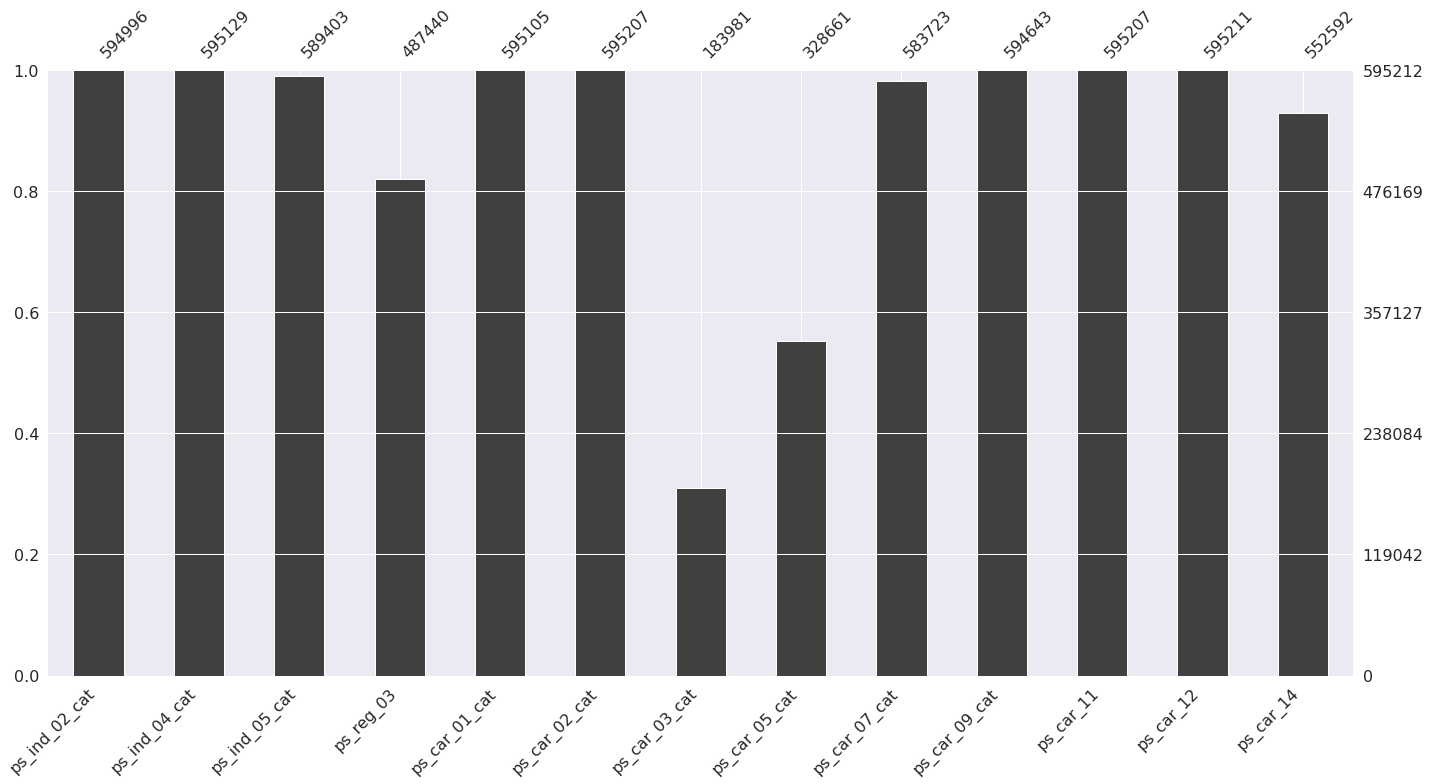

In [224]:
# show a quantidade de missing por columns
msno.bar(df_null, 
         figsize=(20,11),
         labels=True,
         color=(0.25, 0.25, 0.25));

<br/>

### Correlations Between Missing Values
- Very important analysis missing values.
- Simple solution: `values_missing = -1`

### Heatmap

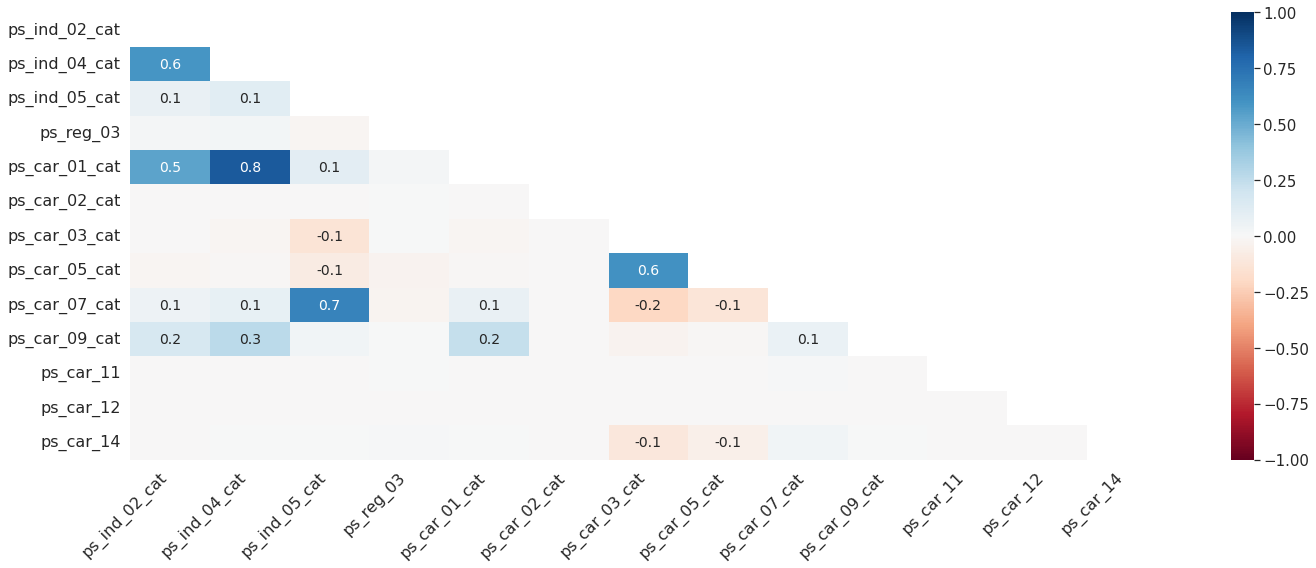

In [225]:
msno.heatmap(df_null,figsize=(20,8));

<br/>

### Dendrogram

- Denogram is used to visualize correlations
- The depth (y-axis) indicates the correlation between the variables
- _ps_car_01_cat_ is highly correlated with _ps_ind_04_cat_ because (axis Y = 0)

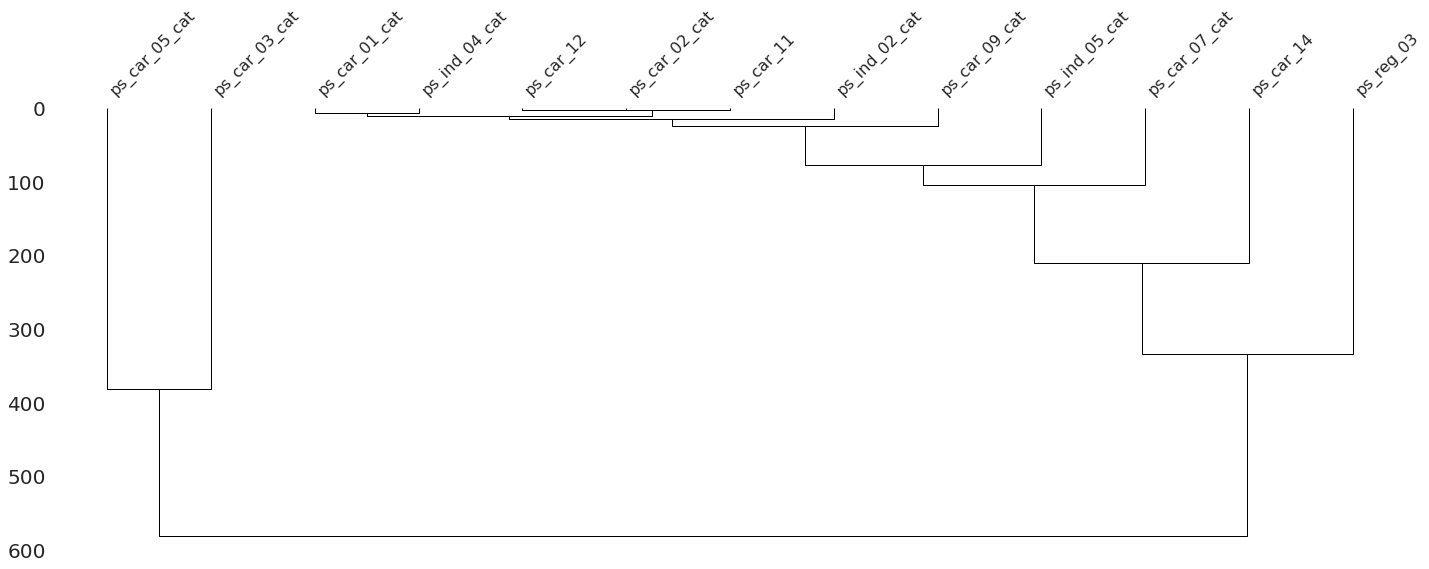

In [226]:
msno.dendrogram(df_null, figsize=(20,8));

<br/>

### Distribution of Columns with Missing Values

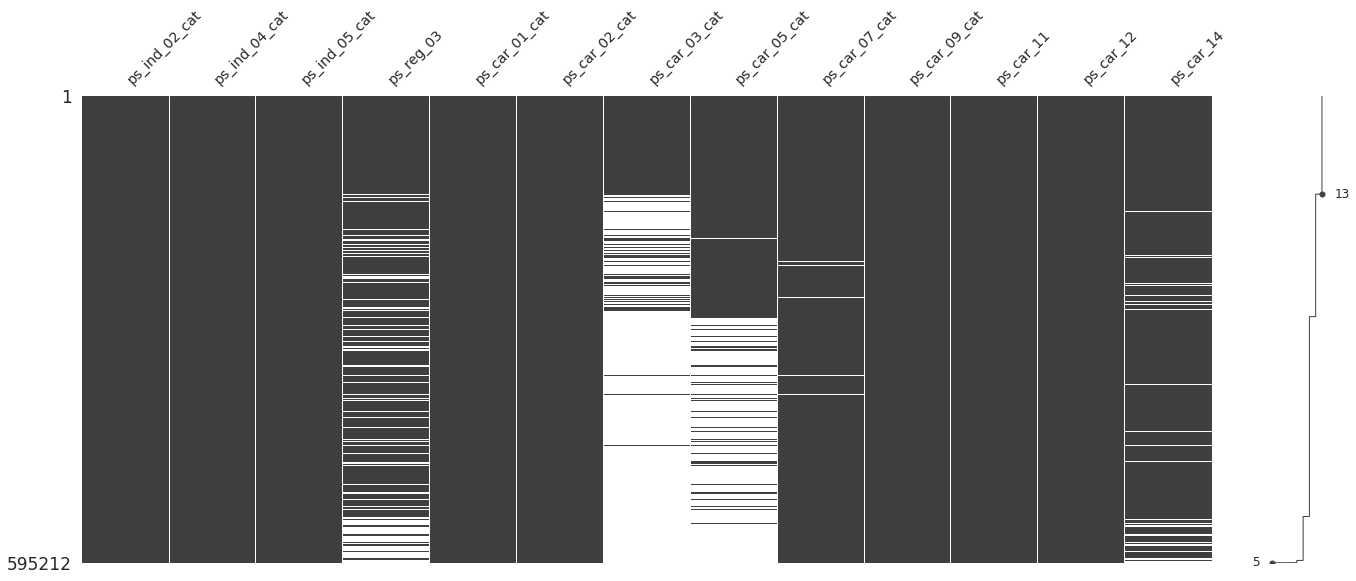

In [227]:
sorted_data = msno.nullity_sort(df_null, sort='descending')
msno.matrix(sorted_data, figsize=(20,8), fontsize=14, color=(0.25, 0.25, 0.25));

---

## **Data Preparation**

<br/>

### Fill Missing Values

In [228]:
# fill all missing values with (-1)
df_train.fillna(-1, inplace=True)
df_train.fillna(-1, inplace=True)

<br/>

### Feature Importance

In [229]:
def get_feature_importance_df(feature_importances,
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame"""
     
    imp_dict = dict(zip(column_names, feature_importances))
    
    # get name features sroted
    top_features = sorted(imp_dict, key=imp_dict.get, reverse=True)[0:top_n]
    
    # get values
    top_importances = [imp_dict[feature] for feature in top_features]
    
    # create dataframe with feature_importance
    return pd.DataFrame(data={'feature': top_features, 'importance': top_importances})

In [230]:
rf = RandomForestClassifier(n_estimators=150, # numbers tree
                            max_depth=8,
                            min_samples_leaf=4,
                            max_features=0.2, # each tree utility 20% in the features
                            n_jobs=-1,
                            random_state=42)

In [231]:
# trainning model
rf.fit(df_train.drop(['target'], axis=1), train.target)
features = df_train.drop(['target'], axis=1).columns.values
print("---Traing Done---")

---Traing Done---


In [232]:
# get trained model (rf) and avalible the feature_importance
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

# print 25 feature_importance in the rf randomForest
feature_importance

,feature,importance
0,ps_car_13,0.13
1,ps_ind_05_cat,0.07
2,ps_reg_03,0.07
3,ps_ind_17_bin,0.06
4,ps_ind_03,0.04
5,ps_reg_02,0.04
6,id,0.04
7,ps_car_07_cat,0.03
8,ps_car_04_cat,0.03
9,ps_car_14,0.03


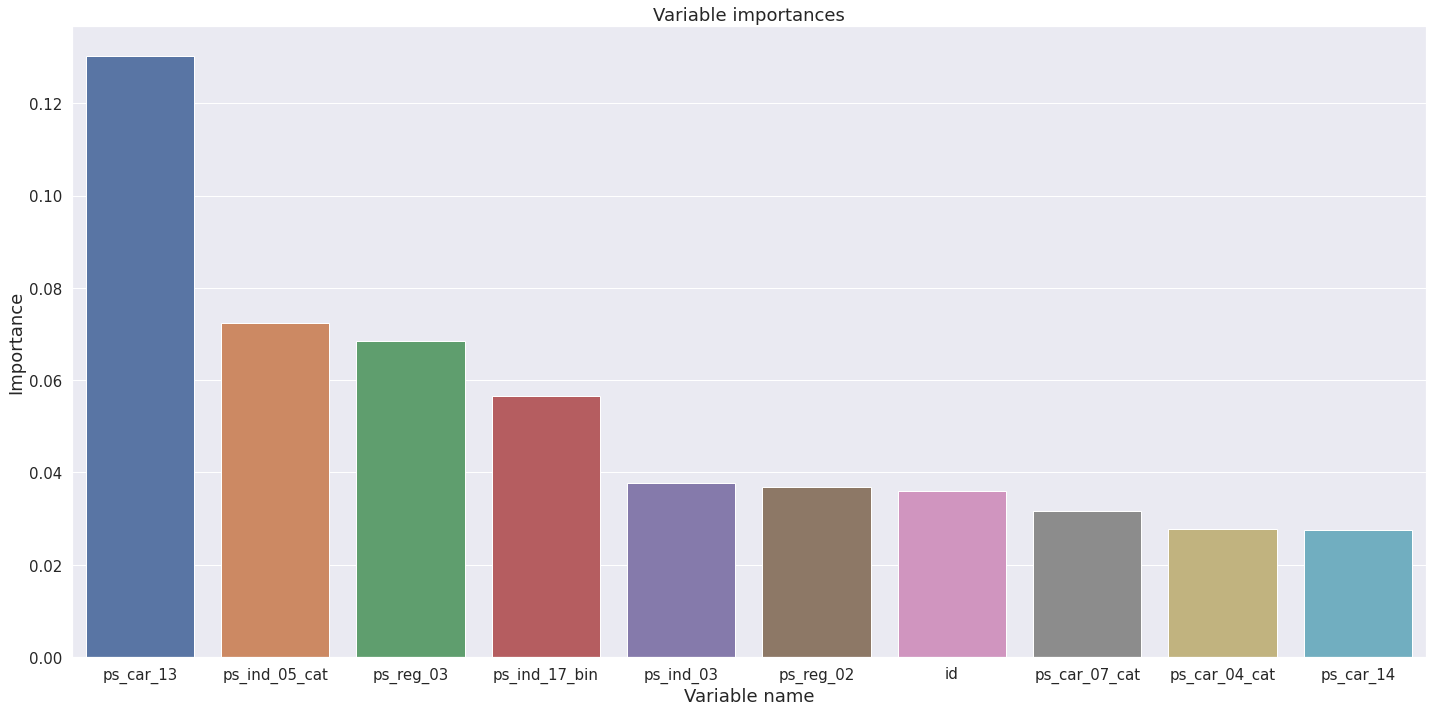

In [233]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:10], 
            x="feature", 
            y="importance", 
            ax=ax)
ax.set(xlabel='Variable name',
       ylabel='Importance',
       title="Variable importances");

In [234]:
def get_without_importance(df_feature_importance: pd.core.frame.DataFrame) -> list:
    list_drop_col = []
              
    cond_duracao = (df_feature_importance['importance'] < 0.01)
    df_temp = df_feature_importance[cond_duracao]
    
    list_drop_col = df_temp['feature'].tolist()
    
    print("-"*25, "FEATURE WITHOUT IMPORTANCE", "-"*25, end='\n\n')
    print(df_temp)
    return list_drop_col

In [235]:
def remove_without_importace(df: pd.core.frame.DataFrame, list_without_imp: list) -> int:
    print(f'Columns before = {df.shape[1]}')
    
    for column in list_without_imp:
        del df[column]
        
    return print(f"Columns after = {df.shape[1]}")

In [236]:
list_without_importance = get_without_importance(df_feature_importance = feature_importance)

------------------------- FEATURE WITHOUT IMPORTANCE -------------------------

Empty DataFrame
Columns: [feature, importance]
Index: []


---

## **Evaluation**

In [237]:
def cross_val_model(X,y, model, n_splits=3):
    'Do split dataset and calculate cross_score'
    X = np.array(X)
    y = np.array(y)
    folds = list(StratifiedKFold(n_splits=n_splits,
                                 shuffle=True,
                                 random_state=2017).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f" % cross_score.mean())

---

## **Modeling**

### Baseline Models

Start base_line be **very simple**:    
- missing_values = -1
- E.g: logistic_regression, random_forest, median

### Random Forest Model

- Each tree have your dataset and features

In [238]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 6
rf_params['n_jobs'] = -1 # run all process

In [239]:
# create model
rf_model = RandomForestClassifier(**rf_params)

# training model
X = df_train.drop('target',axis=1)
y = df_train['target']

In [240]:
# split dataset and calculate cross_score
cross_val_model(X, y, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.52208
Fit RandomForestClassifier fold 2
    cross_score: 0.56846
Fit RandomForestClassifier fold 3
    cross_score: 0.58018


<br/>

### XGBoost Model
- Model very robust
- descentent gradient 
- regularization parameter: help avoid overfitting
- parallelizable

In [241]:
# XGBoost params
xgb_params = {}
xgb_params['learning_rate'] = 0.02
xgb_params['n_estimators'] = 100
xgb_params['max_depth'] = 6
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9
xgb_params['boosting'] = 'gbdt'
xgb_params['metric'] = 'multiclass'
xgb_params['eval_metric'] = 'mlogloss'

In [242]:
# create model
XGB_model = XGBClassifier(**rf_params)

# training model
X = df_train.drop('target',axis=1)
y = df_train['target']

In [243]:
cross_val_model(X, y, XGB_model)

Fit XGBClassifier fold 1
[11:37:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:38:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:39:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:39:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd l

In [244]:
# Check columns train (X) equals in dataframe test
column = X.columns
df_test = df_test[column]

---

## **Save Clean Data**

In [245]:
def save_data_clenning(df: pd.core.frame.DataFrame,
                       path: str = 'data/cleansing/') -> None:
    df.to_csv(path_or_buf = path,
              sep = ',',
              index = False,
              encoding = 'utf8')
    
    return "saved data!"

In [246]:
submission = pd.DataFrame(columns=['id', 'target'])
submission['id'] = id_test
submission['target'] = rf_model.predict_proba(test)[:, 1] # get all rows in the column 'id'

save_data_clenning(df = submission,
                   path = 'data/kaggle_submission.csv')

'saved data!'

---